In [925]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib as mpl 
import matplotlib.animation as animation

plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

Read maps from files

In [926]:
with open('maps3d_X.npy', 'rb') as f: X_map = np.load(f)
with open('maps3d_logT.npy', 'rb') as f: logT_map = np.load(f)
with open('maps3d_Sxx.npy', 'rb') as f: Sxx_map = np.load(f)
with open('maps3d_Sxy.npy', 'rb') as f: Sxy_map = np.load(f)
with open('maps3d_Sxz.npy', 'rb') as f: Sxz_map = np.load(f)
NX = len(X_map); NlogT = len(logT_map)
dx = X_map[1]-X_map[0]
L = float(NX/2)*dx
logdT = logT_map[0]
IF = logT_map[1]-logT_map[0]
assert np.shape(Sxx_map)[0] == NlogT; assert np.shape(Sxx_map)[1] == NX; assert np.shape(Sxx_map)[2] == NX; assert np.shape(Sxx_map)[3] == NX
print(X_map)

[-3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.
 -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8
  2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6]


Function to read maps

In [927]:
def QuadrilinearInterpolation(Map, N0, I0, J0, K0, WX, WY, WZ, WT):
  CXXX = np.zeros((2,2,2)); CXX = np.zeros((2,2)); CX = np.zeros(2)
  # Time interpolation
  for i in range(2):
     for j in range(2):
        for k in range(2):
           CXXX[i][j][k] = Map[N0][I0+i][J0+j][K0+k]*(1.0-WT) + Map[N0+1][I0+i][J0+j][K0+k]*WT
  # X-interpolation
  for i in range(2):
    for j in range(2):
        CXX[i][j] = CXXX[0][i][j]*(1.0-WX) + CXXX[1][i][j]*WX
  # Y-interpolation
  for i in range(2):
    CX[i] = CXX[0][i]*(1.0-WY) + CXX[1][i]*WY
  # Z-interpolation
  return CX[0]*(1.0-WZ) + CX[1]*WZ

def AveragedTransientStokeslet(h, nut):
  return (1.0 / (4.0 * np.pi * h) - np.sqrt(nut / np.pi) * np.exp(-h * h / (4.0 * nut)) / (2.0 * np.pi * h * h) - (h * h - 2.0 * nut) * special.erf(h / (2.0 * np.sqrt(nut))) / (4.0 * np.pi * h * h * h))
def H1Normalized(r, t):
  return (1.0 / (8.0 * np.pi * r)) * (1.0 + (2.0 / r) * np.sqrt(t / np.pi) * np.exp(-r * r / (4.0 * t)) - (1.0 + 2.0 * t / (r * r)) * special.erf(r / np.sqrt(4.0 * t)))
def H2Normalized(r, t):
  return (1.0 / (8.0 * np.pi * r * r * r)) * (1.0 - (6.0 / r) * np.sqrt(t / np.pi) * np.exp(-r * r / (4.0 * t)) - (1.0 - 6.0 * t / (r * r)) * special.erf(r / np.sqrt(4.0 * t)))

In [928]:
def Smat(x, t, xm, delta, tau):
  if t <= 0: return np.zeros((3,3))
  T = t/tau; logT = np.log10(T)
  Xrel = np.array(x-xm)/delta
  N0 = int(np.floor((logT-logdT)/IF)); N1 = int(np.ceil((logT-logdT)/IF))
  I0 = int(np.floor(Xrel[0]/dx)) + int(NX/2); J0 = int(np.floor(Xrel[1]/dx)) + int(NX/2); K0 = int(np.floor(Xrel[2]/dx)) + int(NX/2)

  if N0 >= 0:
    logT0 = logT_map[N0]; logT1 = logT_map[N1]; WT = (logT-logT0)/IF
    if (0 <= I0 < NX-1 and 0 <= J0 < NX-1 and 0 <= K0 < NX-1):
      X0 = X_map[I0]; Y0 = X_map[J0]; Z0 = X_map[K0]
      WX = (Xrel[0]-X0)/dx; WY = (Xrel[1]-Y0)/dx; WZ = (Xrel[2]-Z0)/dx
      Sxx = QuadrilinearInterpolation(Sxx_map, N0, I0, J0, K0, WX, WY, WZ, WT)
      Sxy = QuadrilinearInterpolation(Sxy_map, N0, I0, J0, K0, WX, WY, WZ, WT)
      Sxz = QuadrilinearInterpolation(Sxz_map, N0, I0, J0, K0, WX, WY, WZ, WT)
      Syy = QuadrilinearInterpolation(Sxx_map, N0, J0, K0, I0, WY, WZ, WX, WT)
      Syz = QuadrilinearInterpolation(Sxy_map, N0, J0, K0, I0, WY, WZ, WX, WT)
      Szz = QuadrilinearInterpolation(Sxx_map, N0, K0, I0, J0, WZ, WX, WY, WT)
      return (1/delta)*np.array([[Sxx,Sxy,Sxz],[Sxy,Syy,Syz],[Sxz,Syz,Szz]])
    else:
      r = np.linalg.norm(Xrel)
      H1 = H1Normalized(r, T); H2 = H2Normalized(r, T)
      return (1/delta)*(H1*np.identity(3)+H2*np.outer(Xrel,Xrel))
  else:
    WT = T/10**logdT
    if (0 <= I0 < NX-1 and 0 <= J0 < NX-1 and 0 <= K0 < NX-1):
      X0 = X_map[I0]; Y0 = X_map[J0]; Z0 = X_map[K0]
      WX = (Xrel[0]-X0)/dx; WY = (Xrel[1]-Y0)/dx; WZ = (Xrel[2]-Z0)/dx
      Sxx = QuadrilinearInterpolation(Sxx_map, 0, I0, J0, K0, WX, WY, WZ, 0)
      Sxy = QuadrilinearInterpolation(Sxy_map, 0, I0, J0, K0, WX, WY, WZ, 0)
      Sxz = QuadrilinearInterpolation(Sxz_map, 0, I0, J0, K0, WX, WY, WZ, 0)
      Syy = QuadrilinearInterpolation(Sxx_map, 0, J0, K0, I0, WY, WZ, WX, 0)
      Syz = QuadrilinearInterpolation(Sxy_map, 0, J0, K0, I0, WY, WZ, WX, 0)
      Szz = QuadrilinearInterpolation(Sxx_map, 0, K0, I0, J0, WZ, WX, WY, 0)
      return (1/delta)*WT*np.array([[Sxx,Sxy,Sxz],[Sxy,Syy,Syz],[Sxz,Syz,Szz]])
    else:
      r = np.linalg.norm(Xrel)
      H1 = H1Normalized(r, T); H2 = H2Normalized(r, T)
      return (1/delta)*(H1*np.identity(3)+H2*np.outer(Xrel,Xrel))


In [929]:
x = 2*np.random.rand(3)-1
t = np.random.rand()
xm = np.zeros(3)

print("Calling S with x = ", x, " and t = ", t)
print(Smat(x,t,xm,1,1))

Calling S with x =  [-0.20354453 -0.05630718  0.4886204 ]  and t =  0.563690160828844
[[ 0.0525577   0.00107596 -0.00954947]
 [ 0.00107596  0.04936717 -0.00248696]
 [-0.00954947 -0.00248696  0.07158253]]


In [930]:
def SeedSphere(M, a):
  N = M  # Number of points on our sphere
  da = 4.0 * np.pi / N  
  d = np.sqrt(da)
  M_theta = int(round(np.pi / d))
  d_theta = np.pi / M_theta
  d_phi = da / d_theta
  Xm = []

  for m in range(M_theta):
      theta = (np.pi * (m + 0.5)) / M_theta
      M_phi = int(round(((2 * np.pi) * np.sin(theta)) / d_phi))
      for n in range(M_phi):
          phi = (2 * np.pi * n) / M_phi
          x = a * np.sin(theta) * np.cos(phi)
          y = a * np.sin(theta) * np.sin(phi)
          z = a * np.cos(theta)
          vector = np.array([x, y, z])
          Xm.append(vector)
  Xm = np.array(Xm)
  return len(Xm), Xm 


In [931]:
def VizFromSources(sources, Mviz, Uinf, a, eps, tau, t, ax):
  uviz = Uinf * np.ones((Mviz,Mviz)); vviz = np.zeros((Mviz,Mviz)); xviz = np.linspace(-3*a,3*a,num=Mviz); yviz = np.linspace(-3*a,3*a,num=Mviz)
  for s in range(len(sources)):
    Xsource = sources[s][0]; Fsource = sources[s][1]; t0 = sources[s][2]; t1 = sources[s][3]
    for i in range(Mviz):
      for j in range(Mviz):
        x = np.array([xviz[i],yviz[j],0])
        for k in range(len(Xsource)):
          Sdiff = Smat(x, t-t0, Xsource[k], eps, tau) - Smat(x, t-t1, Xsource[k], eps, tau)
          Udiff = Sdiff@Fsource[3*k:3*(k+1)]
          uviz[j][i] += Udiff[0]
          vviz[j][i] += Udiff[1]
  img = ax.imshow(uviz, interpolation='nearest', cmap='viridis', vmin=0, vmax=Uinf, extent =[-3*a,3*a,-3*a,3*a])
  step=1; arrow = ax.quiver(xviz[::step], yviz[::step], uviz[::step,::step], vviz[::step,::step])
  # text = ax.text(0,0, r'$t = %.2e \tau' % (t/tau), ha='center', va='center', fontsize=12, color='white')
  return img, arrow


In [932]:
Re = 1e-3

a = 1.0
Uinf = 1.0
nu = a*Uinf/Re
M = 100
eps = 2.0*np.sqrt(4.0*np.pi*a**2/float(M))
tau = eps**2/nu
dt = 0.01*min(tau,a/Uinf)
Nt = 1

5.02654824574367e-06


Solving
t = 0.00e+00/5.03e-05
t = 5.03e-06/5.03e-05
t = 1.01e-05/5.03e-05
t = 1.51e-05/5.03e-05
t = 2.01e-05/5.03e-05
t = 2.51e-05/5.03e-05
t = 3.02e-05/5.03e-05
t = 3.52e-05/5.03e-05
t = 4.02e-05/5.03e-05
t = 4.52e-05/5.03e-05


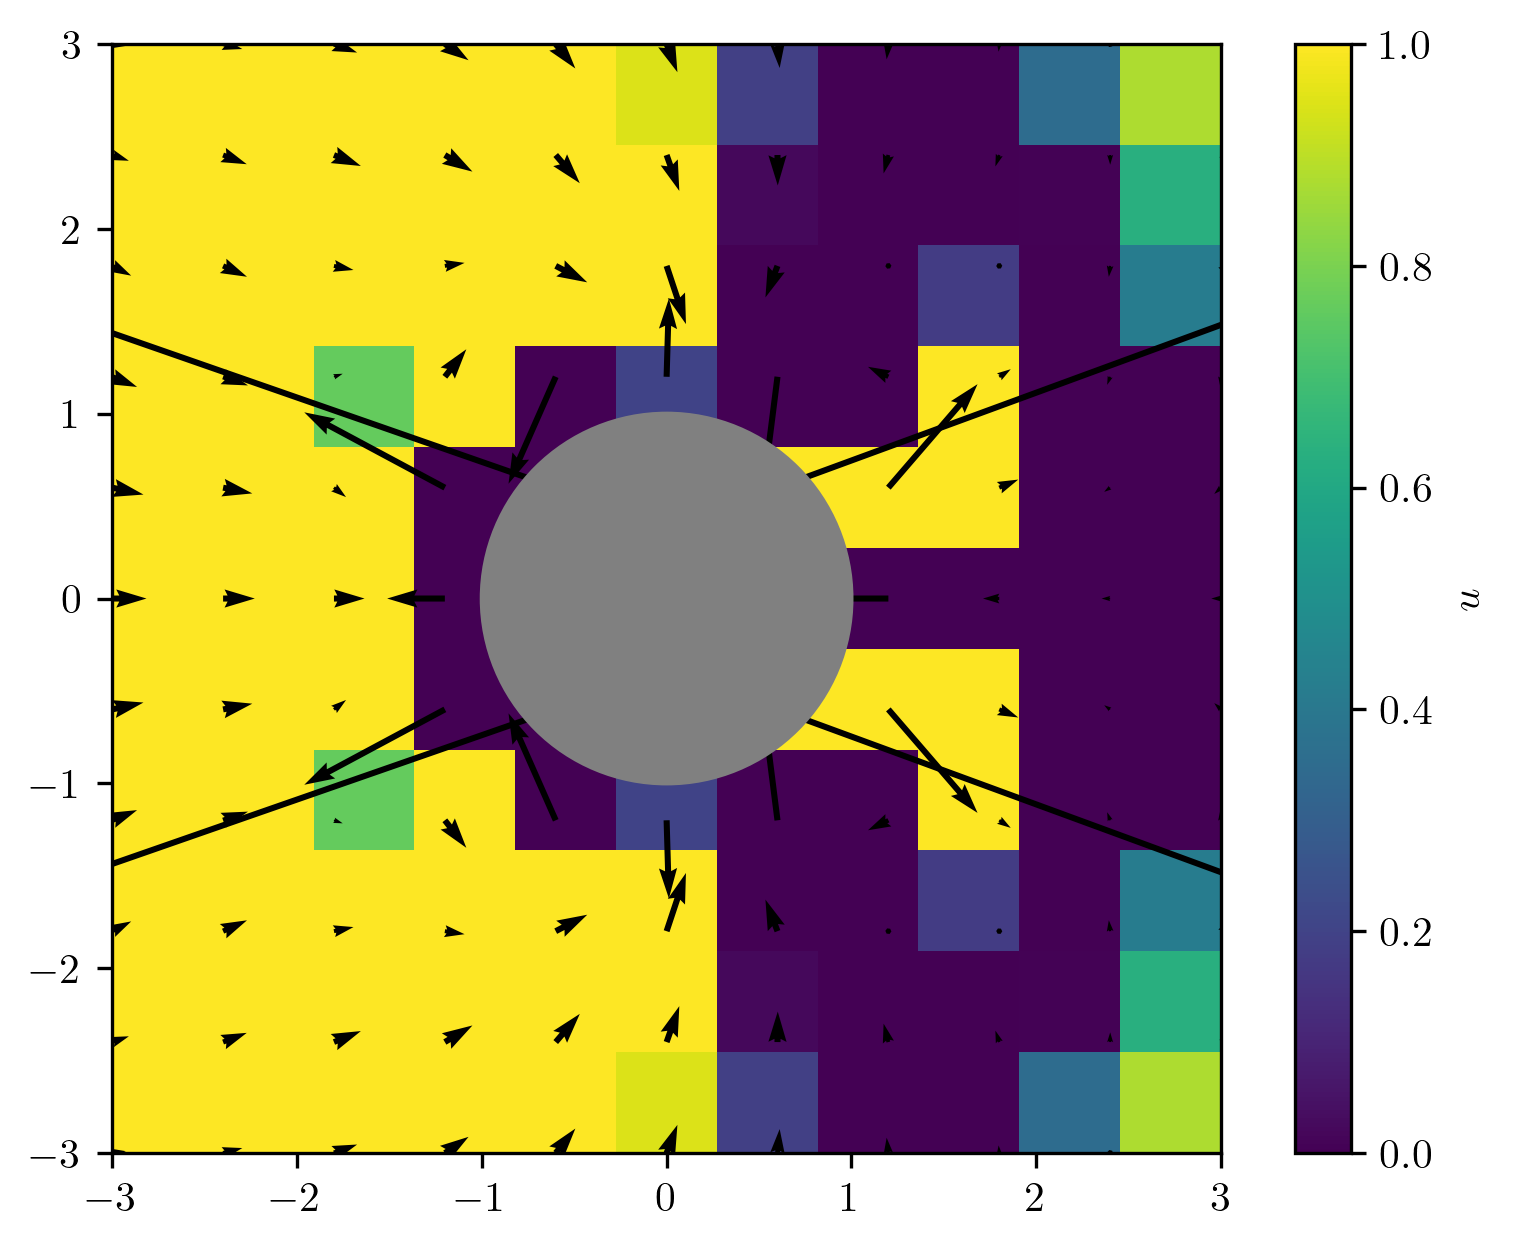

In [933]:

M, Xm = SeedSphere(M, a)
# M = 1
# Xm = np.array([[0.0,0.0,0.0]])

print("Solving")
Mat0 = np.zeros((3*M,3*M)); Mat1 = np.zeros((3*M,3*M))
t = 0
sources = []
frames = []
fig, ax = plt.subplots()
ax.set(xlim=(-3*a,3*a), ylim = (-3*a,3*a)); ax.set_aspect(1)
for n in range(Nt):
  print("t = %.2e/%.2e" %(t, Nt*dt))
  # Init RHS to zero
  RHS = np.zeros((3*M))
  # Loop over markers
  for k in range(M): 
    # Assume Uinf along x-direction
    RHS[3*k] = -Uinf
    # Subtract influence from previous forcing instances
    for s in range(len(sources)):
      Xsource = sources[s][0]; Fsource = sources[s][1]; t0 = sources[s][2]; t1 = sources[s][3]
      for l in range(M):
        Sdiff = Smat(Xm[k], t+dt-t0, Xsource[l], eps, tau) - Smat(Xm[k], t+dt-t1, Xsource[l], eps, tau)
        RHS[3*k:3*(k+1)] -= Sdiff@Fsource[3*l:3*(l+1)]
    # Compute coeffs for dt
    for l in range(M):
      Mat1[3*k:3*(k+1),3*l:3*(l+1)] = Smat(Xm[k], dt, Xm[l], eps, tau)
  f = np.linalg.solve(Mat1,RHS)
  Mat0 = np.copy(Mat1)
  sources.append([np.copy(Xm), np.copy(f), t, t+dt])
  # sources.append([np.copy(Xm), np.array([-50.0,0.0,0.0]), t, t+dt])
  t += dt
  dt *= 1
  if (n%1==0): frames.append(VizFromSources(sources, 11, Uinf, a, eps, tau, t, ax))
  for s in range(len(sources)):
    for l in range(M):
      sources[s][0][l][0] += dt*Uinf

# Save video
ax.add_patch(Circle((0,0),a,zorder=2,color='gray'))
fig.colorbar(mpl.cm.ScalarMappable(cmap='viridis'), ax=ax, orientation='vertical', label=r'$u$')

anim = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
writergif = animation.PillowWriter(fps=5)
anim.save('mtrs.gif', writer=writergif)
writermp4 = animation.FFMpegWriter(fps=5)  # Use FFMpegWriter for MP4
anim.save('mtrs.mp4', writer=writermp4)
